In [1]:
# Plotly credentials stuff- run first time only
import plotly
plotly.tools.set_credentials_file(username='bdesnoy', api_key='VLNSHIH0dfFWjlXNEbiG')
# plotly.tools.set_credentials_file(username='junyi', api_key='sswCNaXW5ssm3JllQCRq')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
import pandas as pd
import plotly.plotly as py
from re import match
import statistics as stat

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

# Load the Dataset

In [4]:
data = pd.read_csv('behavioral_risk_factor_dataset.csv')

In [5]:
# Convert question to a category and rename categories for visibility
data["Question"] = data["Question"].astype("category")
data['Question'].cat.categories = ["% Overweight Adults",
                                   "% Obese Adults",
                                   "% Mod Aerobic", 
                                   "% Mod Aerobic & Strength", 
                                   "% Vigerous Aerobic", 
                                   "% Strength", 
                                   "% No Phys. Activity", 
                                   "% < 1 Fruit / Day", 
                                   "% < 1 Veg / Day"]

# Drop, unnecessary columns to make table human-readable
cols_to_drop = ['Datasource', 'Class', 'Topic', 'Data_Value_Unit', 
                'Data_Value_Type', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 
                'Data_Value_Footnote', 'Total', 'Age(years)', 'Education',
                'Gender', 'Income', 'Race/Ethnicity', 'ClassID', 
                'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID']
data.drop(cols_to_drop, axis = 1, inplace = True)

# remove 'Guam' ,'Puerto Rico', 'Virgin Islands'
data = data[data.LocationAbbr != 'VI']
data = data[data.LocationAbbr != 'PR']
data = data[data.LocationAbbr != 'GU']

In [6]:
list(data.columns)

['YearStart',
 'YearEnd',
 'LocationAbbr',
 'LocationDesc',
 'Question',
 'Data_Value',
 'Low_Confidence_Limit',
 'High_Confidence_Limit ',
 'Sample_Size',
 'GeoLocation',
 'StratificationCategory1',
 'Stratification1',
 'StratificationCategoryId1',
 'StratificationID1']

# Preview the Dataset

In [7]:
data.head(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,Question,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AL,Alabama,% Obese Adults,32.0,30.5,33.5,7304.0,"(32.84057112200048, -86.63186076199969)",Total,Total,OVR,OVERALL
1,2011,2011,AL,Alabama,% Obese Adults,32.3,29.9,34.7,2581.0,"(32.84057112200048, -86.63186076199969)",Gender,Male,GEN,MALE
2,2011,2011,AL,Alabama,% Obese Adults,31.8,30.0,33.6,4723.0,"(32.84057112200048, -86.63186076199969)",Gender,Female,GEN,FEMALE
3,2011,2011,AL,Alabama,% Obese Adults,33.6,29.9,37.6,1153.0,"(32.84057112200048, -86.63186076199969)",Education,Less than high school,EDU,EDUHS
4,2011,2011,AL,Alabama,% Obese Adults,32.8,30.2,35.6,2402.0,"(32.84057112200048, -86.63186076199969)",Education,High school graduate,EDU,EDUHSGRAD


# Grab 2016 Data

In [8]:
data_2016 = data.query('YearStart == "2016"')

data_2016.head(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,Question,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
48772,2016,2016,US,National,% Overweight Adults,35.2,34.9,35.5,438479.0,NaN,Total,Total,OVR,OVERALL
48773,2016,2016,US,National,% Overweight Adults,41.0,40.6,41.5,198440.0,NaN,Gender,Male,GEN,MALE
48774,2016,2016,US,National,% Overweight Adults,29.3,28.9,29.7,240000.0,NaN,Gender,Female,GEN,FEMALE
48775,2016,2016,US,National,% Overweight Adults,34.7,33.6,35.7,32325.0,NaN,Education,Less than high school,EDU,EDUHS
48776,2016,2016,US,National,% Overweight Adults,34.2,33.7,34.8,123241.0,NaN,Education,High school graduate,EDU,EDUHSGRAD


# Visualizing Obesity by Location

In [9]:
def get_table_from_query(df, query):
    filtered_data = df.query(query)
    filtered_data = filtered_data.query('LocationAbbr != "US"')
    mean_over_years = filtered_data.groupby(['LocationAbbr', 'Question', 'StratificationCategoryId1', 'StratificationID1'])['Data_Value'].mean()
    filtered_data.drop_duplicates(['LocationAbbr', 'Question', 'StratificationCategoryId1', 'StratificationID1'], keep='last', inplace=True)
    filtered_data.set_index(['LocationAbbr', 'Question', 'StratificationCategoryId1', 'StratificationID1'], inplace=True)
    filtered_data['Data_Value'] = mean_over_years
    filtered_data.reset_index(inplace=True)
    return filtered_data

def get_total_incidence_table(df, question):
    return get_table_from_query(df, 'StratificationCategory1 == "Total" & Question == "%s"' % (question,))

In [10]:
obesity_data_by_state = get_total_incidence_table(data, "% Obese Adults")
obesity_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,LA,% Obese Adults,OVR,OVERALL,2016,2016,Louisiana,34.633333,33.4,37.7,4868.0,"(31.31266064400046, -92.44568007099969)",Total,Total
1,ME,% Obese Adults,OVR,OVERALL,2016,2016,Maine,28.850000,28.5,31.3,9554.0,"(45.254228894000505, -68.98503133599962)",Total,Total
2,MD,% Obese Adults,OVR,OVERALL,2016,2016,Maryland,28.766667,28.9,31.0,16701.0,"(39.29058096400047, -76.60926011099963)",Total,Total
3,MA,% Obese Adults,OVR,OVERALL,2016,2016,Massachusetts,23.400000,22.3,24.9,7480.0,"(42.27687047000046, -72.08269067499964)",Total,Total
4,MI,% Obese Adults,OVR,OVERALL,2016,2016,Michigan,31.383333,31.4,33.6,11130.0,"(44.6613195430005, -84.71439026999968)",Total,Total


In [11]:
# https://plot.ly/python/matplotlib-colorscales/
# use matplotlib style colorscales
magma_cmap = cm.get_cmap('magma')
viridis_cmap = cm.get_cmap('viridis')

viridis_rgb = []
magma_rgb = []
norm = colors.Normalize(vmin=0, vmax=255)

for i in range(0, 255):
       k = colors.colorConverter.to_rgb(magma_cmap(norm(i)))
       magma_rgb.append(k)

for i in range(0, 255):
       k = colors.colorConverter.to_rgb(viridis_cmap(norm(i)))
       viridis_rgb.append(k)
    
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 255)
viridis = matplotlib_to_plotly(viridis_cmap, 255)

In [12]:
lat_long_regex = "\((-{0,1}[0-9]+.{0,1}[0-9]*),\s*(-{0,1}[0-9]+.{0,1}[0-9]*)\)"
def extract_lat_long(str):
    lat_long_match = match(lat_long_regex, str)
    return lat_long_match.groups()

def extract_lat(str):
    return float(extract_lat_long(str)[0])

def extract_long(str):
    return float(extract_lat_long(str)[1])

extract_lats = np.vectorize(extract_lat)
extract_longs = np.vectorize(extract_long)

In [13]:
# See Plotly Support: https://plot.ly/pandas/scatter-plots-on-maps/

def plot_basic(df, plot_title, bar_title, filename, colorscheme=magma):
    # Extract relevant data from dataframe
    locs = df["GeoLocation"]
    state_names = df["LocationDesc"] + ' (' +  df["Data_Value"].astype('str') + '%)'
    values = pd.to_numeric(df["Data_Value"])
    max_value = values.max()
    min_value = values.min()
    
    # Create a heat-map scale w/ colors for percentages
    state_marker = {'size': 8, 
                    'opacity': 0.8, 
                    'symbol': 'square', 
                    'line': {'width': 1, 
                             'color': 'rgba(102, 102, 102)'}, 
                    'cmin': min_value,
                    'cmax': max_value, 
                    'colorbar': {'title': bar_title}}
    state_bar = {
        'title': bar_title
    }
    plot_data = {'type': 'choropleth', 
                 'reversescale': True, 
                 'colorscale': colorscheme,
                 'locationmode': 'USA-states', 
                 'locations': df["LocationAbbr"],
                 'z': values,
                 'text': state_names, 
                 'mode': 'markers', 
                 'marker': state_marker,
                 'colorbar': state_bar}
        
    plot_layout = {'title': '<b>%s</b><br>(hover for state name and value)' % (plot_title,),
                   'colorbar': True, 
                   'width': 1400,
                   'height': 800,
                   'geo': {'scope': 'usa', 
                           'projection': {'type': 'albers usa'}, 
                           'showland': True, 
                           'landcolor': "rgb(250, 250, 250)",
                           'subunitcolor': "rgb(217, 217, 217)",
                           'countrycolor': "rgb(217, 217, 217)", 
                           'countrywidth': 0.5, 
                           'subunitwidth': 0.5}
                  }

    fig = dict(data=[plot_data], layout=plot_layout)
    return fig

# direct to a plot.ly page with the plot
def show_on_web(fig):
    url = py.plot(fig, validate=False, filename=filename)

# show the plot
def show_on_notebook(fig):
    py.image.ishow(fig)

# save plot to <filename>.png
def save_plot(fig, filename):
    filename += '.png'
    py.image.save_as(fig, filename=filename)


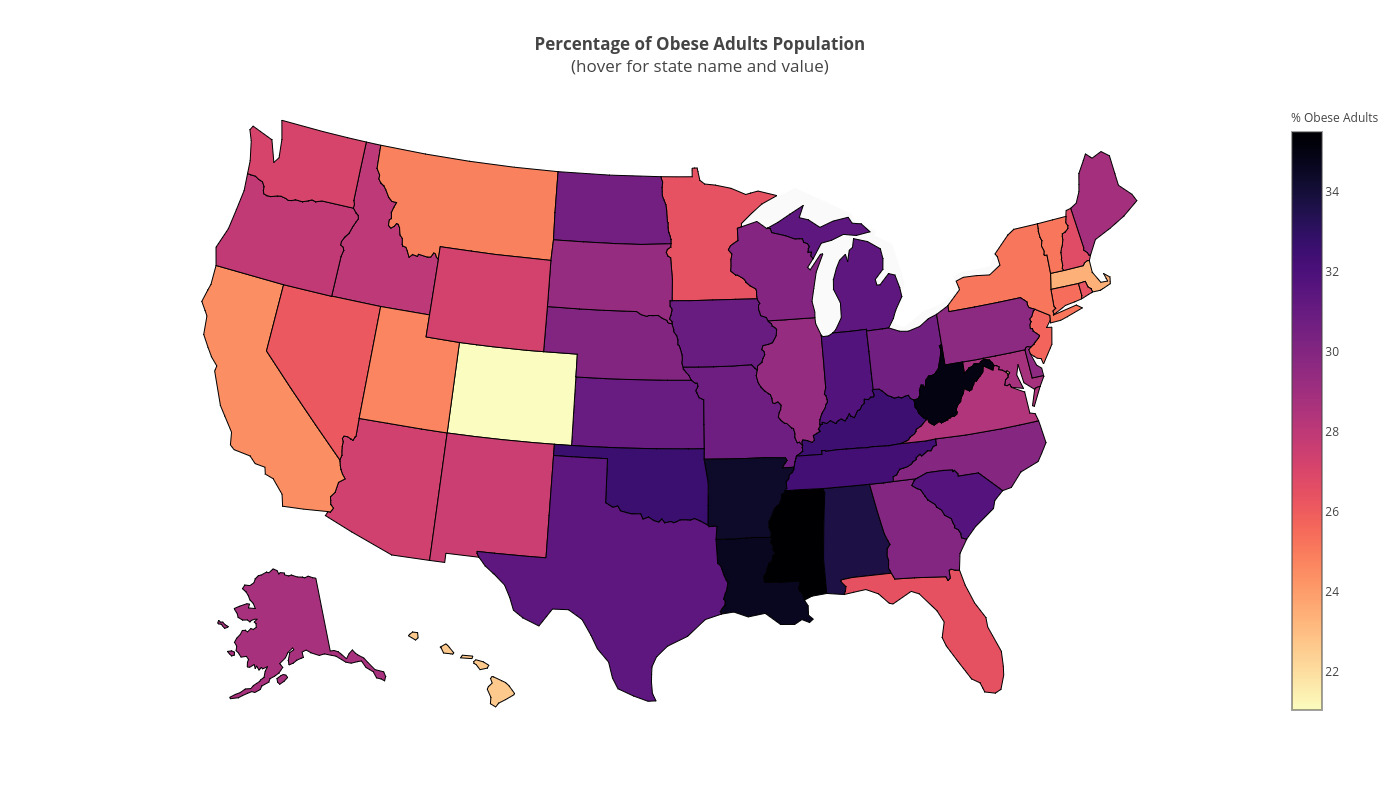

In [14]:
fig = plot_basic(obesity_data_by_state, 
          'Percentage of Obese Adults Population', 
          '% Obese Adults', 
          'd3-obesity')
show_on_notebook(fig)

# Visualizing Overweight Incidence (inc. Obesity) by Location

In [15]:
# Use grouping to get the actual number of overweight adults by state
overwieght_obesity_data = get_table_from_query(data, 'StratificationCategory1 == "Total" & (Question == "% Overweight Adults" | Question == "% Obese Adults")')
overweight_obesity_sum_by_state = overwieght_obesity_data.groupby(['LocationAbbr'])['Data_Value'].sum()

In [16]:
# Update the overweight adults table to use the actual number of overweight adults
overweight_data_by_state = get_total_incidence_table(data, "% Overweight Adults")
overweight_data_by_state.set_index('LocationAbbr', inplace=True)
overweight_data_by_state['LocationAbbr'] = overweight_data_by_state.index
overweight_data_by_state['Data_Value'] = overweight_obesity_sum_by_state
overweight_data_by_state.head(n=5)

,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,LocationAbbr
LocationAbbr,,,,,,,,,,,,,,
AL,% Overweight Adults,OVR,OVERALL,2016,2016,Alabama,67.950000,32.3,35.4,6526.0,"(32.84057112200048, -86.63186076199969)",Total,Total,AL
AK,% Overweight Adults,OVR,OVERALL,2016,2016,Alaska,65.983333,32.4,38.2,2739.0,"(64.84507995700051, -147.72205903599973)",Total,Total,AK
AZ,% Overweight Adults,OVR,OVERALL,2016,2016,Arizona,63.216667,32.7,35.8,10033.0,"(34.865970280000454, -111.76381127699972)",Total,Total,AZ
AR,% Overweight Adults,OVR,OVERALL,2016,2016,Arkansas,68.616667,30.2,34.9,4859.0,"(34.74865012400045, -92.27449074299966)",Total,Total,AR
CA,% Overweight Adults,OVR,OVERALL,2016,2016,California,60.283333,34.8,37.2,10352.0,"(37.63864012300047, -120.99999953799971)",Total,Total,CA


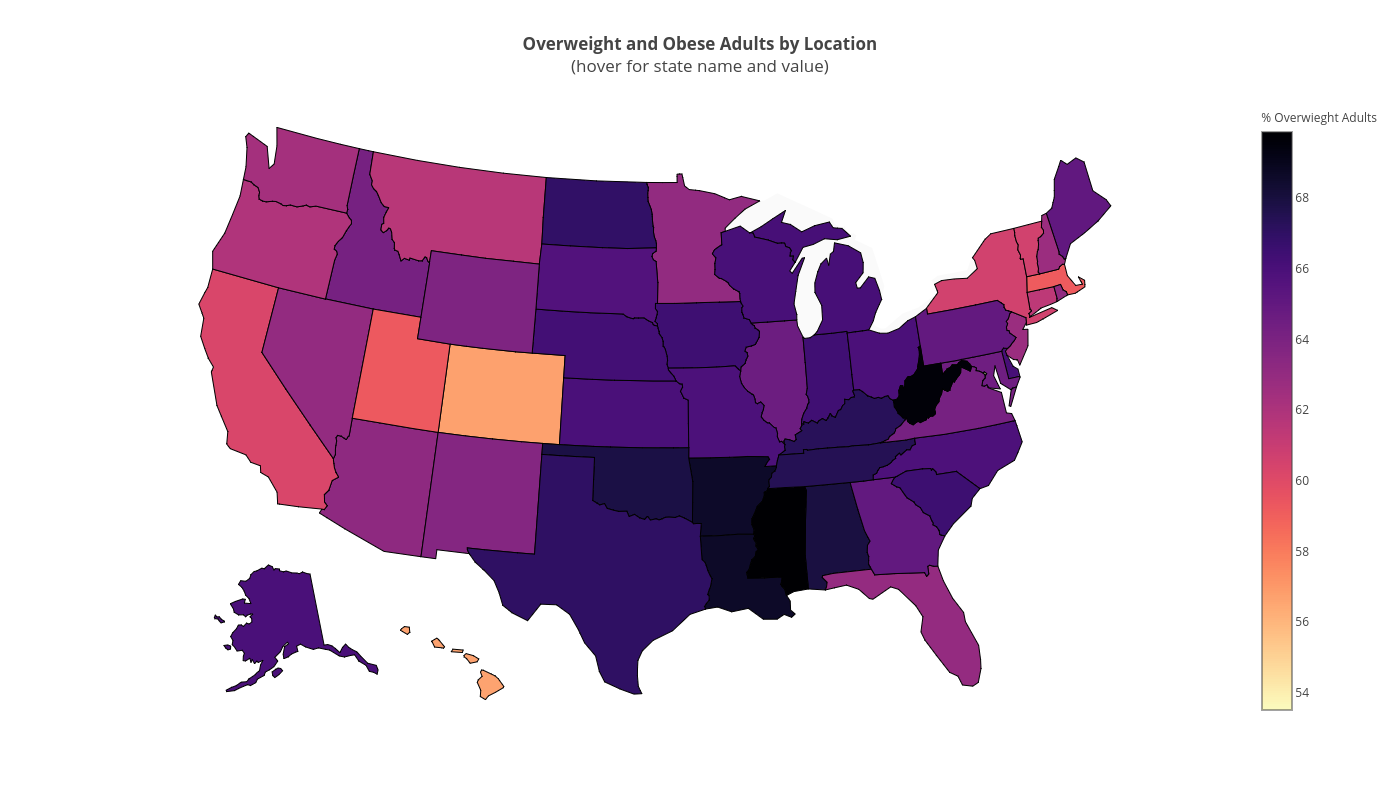

In [17]:
fig = plot_basic(overweight_data_by_state, 
           'Overweight and Obese Adults by Location', 
           '% Overwieght Adults', 
           'd3-overweight')
show_on_notebook(fig)
save_plot(fig, 'd3-overweight')

# Visualizing Inactivity by Location

In [18]:
inactivity_data_by_state = get_total_incidence_table(data, "% No Phys. Activity")
inactivity_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% No Phys. Activity,OVR,OVERALL,2016,2016,Alabama,30.033333,28.0,30.9,7013.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% No Phys. Activity,OVR,OVERALL,2016,2016,Alaska,20.516667,16.6,21.9,2910.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% No Phys. Activity,OVR,OVERALL,2016,2016,Arizona,23.483333,21.7,24.5,10921.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% No Phys. Activity,OVR,OVERALL,2016,2016,Arkansas,32.366667,30.3,34.8,5285.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% No Phys. Activity,OVR,OVERALL,2016,2016,California,20.316667,19.5,21.5,11386.0,"(37.63864012300047, -120.99999953799971)",Total,Total


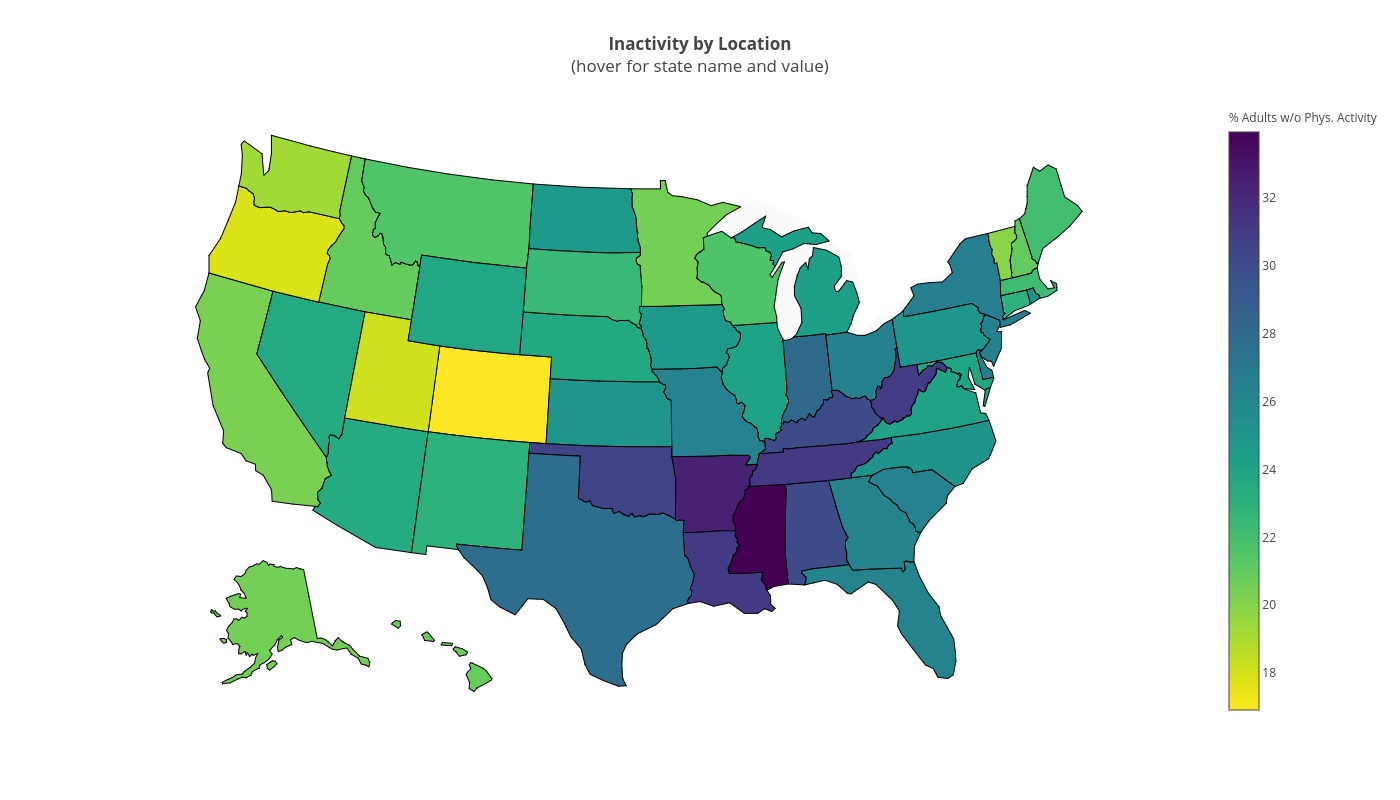

In [19]:
fig = plot_basic(inactivity_data_by_state, 
           'Inactivity by Location', 
           '% Adults w/o Phys. Activity', 
           'd3-inactive', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-inactive')

# Visualizing Vigerous Aerobic Activity by Location

In [20]:
vig_aerobic_by_state = get_total_incidence_table(data, "% Vigerous Aerobic")
inactivity_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% No Phys. Activity,OVR,OVERALL,2016,2016,Alabama,30.033333,28.0,30.9,7013.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% No Phys. Activity,OVR,OVERALL,2016,2016,Alaska,20.516667,16.6,21.9,2910.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% No Phys. Activity,OVR,OVERALL,2016,2016,Arizona,23.483333,21.7,24.5,10921.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% No Phys. Activity,OVR,OVERALL,2016,2016,Arkansas,32.366667,30.3,34.8,5285.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% No Phys. Activity,OVR,OVERALL,2016,2016,California,20.316667,19.5,21.5,11386.0,"(37.63864012300047, -120.99999953799971)",Total,Total


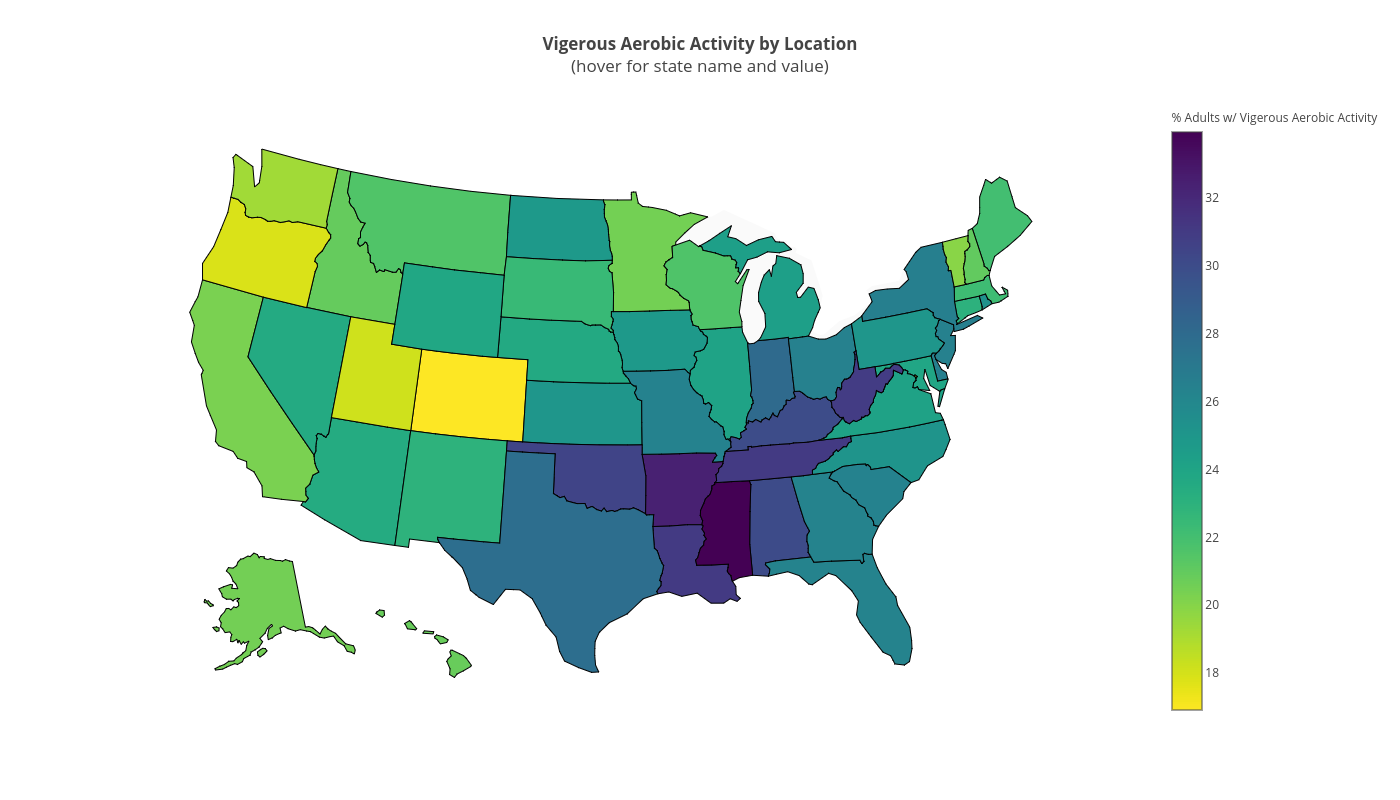

In [21]:
fig = plot_basic(inactivity_data_by_state, 
           'Vigerous Aerobic Activity by Location', 
           '% Adults w/ Vigerous Aerobic Activity', 
           'd3-vigerous', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-vigerous')

# Visualizing Vegetable Malnutrition by Location

In [22]:
veg_data_by_state = get_total_incidence_table(data, "% < 1 Veg / Day")
veg_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Alabama,25.966667,26.3,29.4,6938.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Alaska,19.266667,16.8,21.2,3322.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Arizona,21.633333,19.1,22.1,6905.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Arkansas,28.233333,25.8,30.5,4526.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% < 1 Veg / Day,OVR,OVERALL,2015,2015,California,17.466667,17.6,19.6,10846.0,"(37.63864012300047, -120.99999953799971)",Total,Total


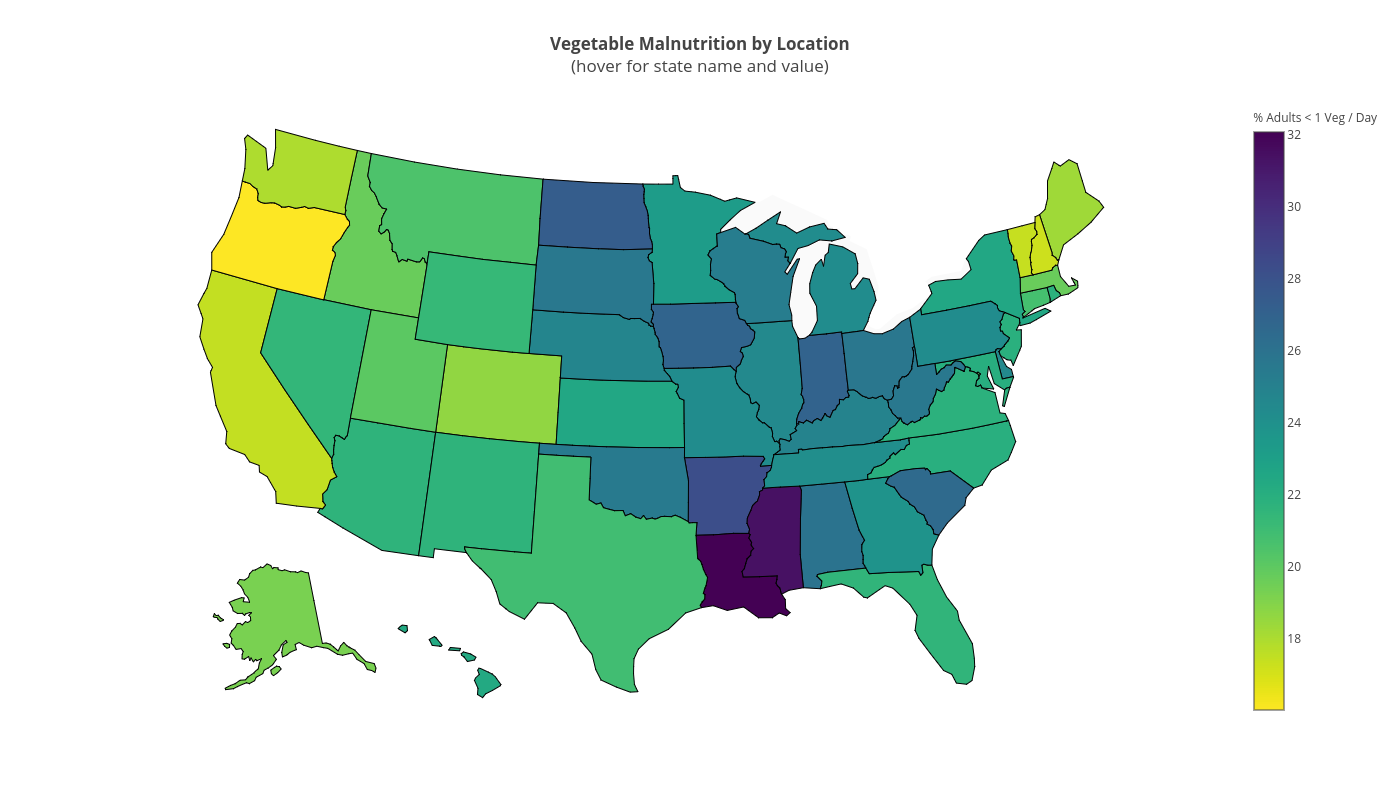

In [23]:
fig = plot_basic(veg_data_by_state, 
           'Vegetable Malnutrition by Location', 
           '% Adults < 1 Veg / Day', 
           'd3-veg', viridis)
show_on_notebook(fig)

# Visualizing Fruit Malnutrition by Location

In [24]:
fruit_data_by_state = get_total_incidence_table(data, "% < 1 Fruit / Day")
fruit_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Alabama,46.033333,46.7,49.9,7124.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Alaska,39.800000,38.3,43.8,3364.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Arizona,39.066667,38.0,41.5,7068.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Arkansas,49.200000,47.1,52.1,4642.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,California,32.200000,34.7,37.0,11086.0,"(37.63864012300047, -120.99999953799971)",Total,Total


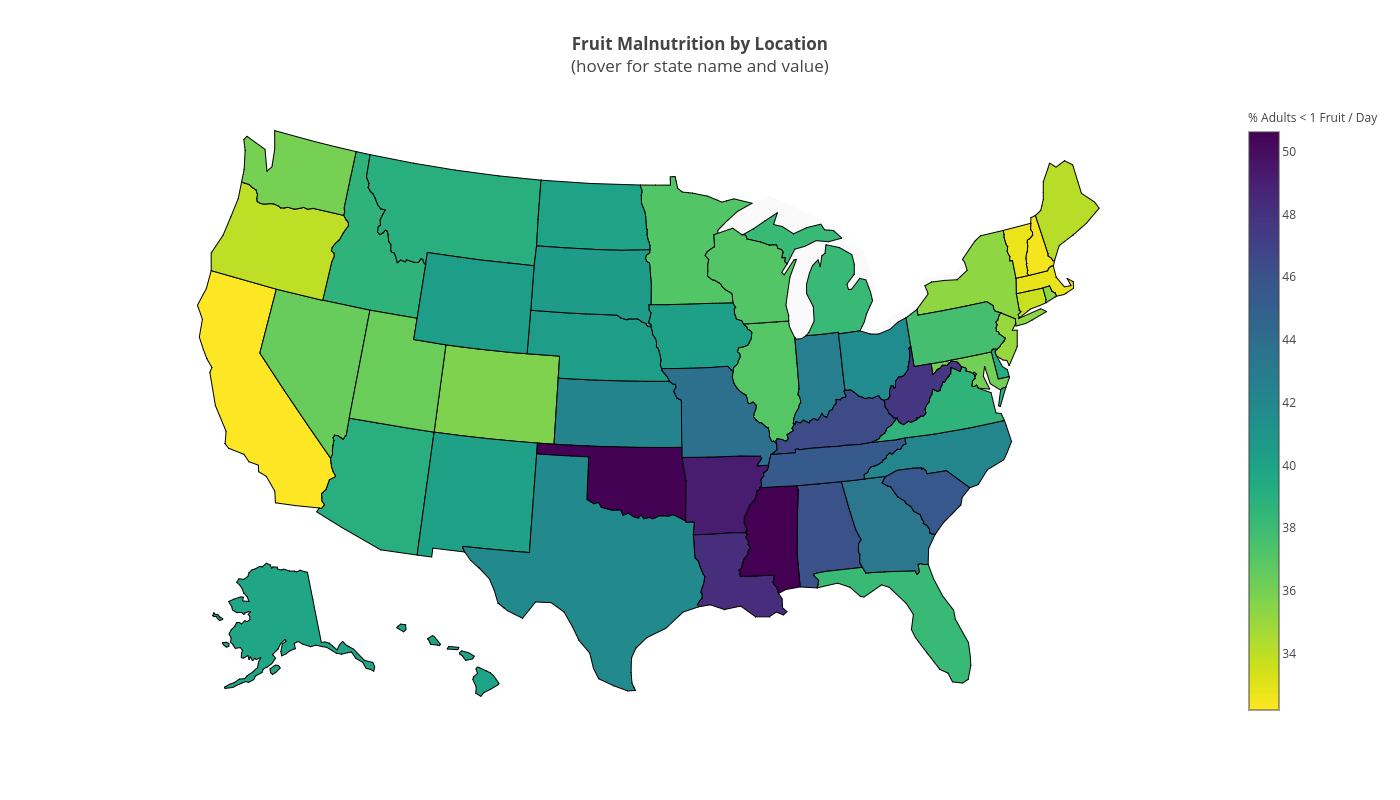

In [25]:
fig = plot_basic(fruit_data_by_state, 
           'Fruit Malnutrition by Location', 
           '% Adults < 1 Fruit / Day', 
           'd3-fruit', viridis)
show_on_notebook(fig)

# Find Mean (over Years) Obesity Percentage by State

In [26]:
states_list = set(obesity_data_by_state['LocationAbbr'].tolist())

In [27]:
Obese_adults_dictionary = {}
for state in states_list:
    Obese_adults_dictionary[state] = []
    
for index, row in obesity_data_by_state.iterrows():
    Obese_adults_dictionary[row['LocationAbbr']].append(row['Data_Value'])
    
avg_obese_adults = {}
for state in Obese_adults_dictionary.keys():
    avg_obese_adults[state] = stat.mean(Obese_adults_dictionary[state])

# Plotting Correlation between Mean (over Years) Fruit Malnutrition and Obesity

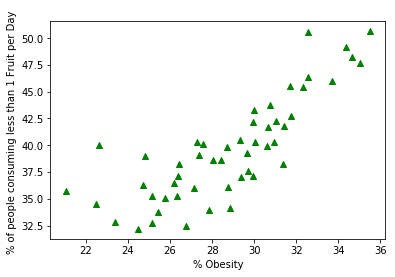

In [28]:
# X-axis: avg % obesity
# Y-axis: avg % of people consuming less than 1 fruit / day
plt.scatter(obesity_data_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           fruit_data_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           marker='^',
           color='g')
plt.xlabel('% Obesity')
plt.ylabel('% of people consuming less than 1 Fruit per Day ')
plt.show()

# Plotting Correlation between Mean (over Years) Vigerous Aerobic Activity and Obesity

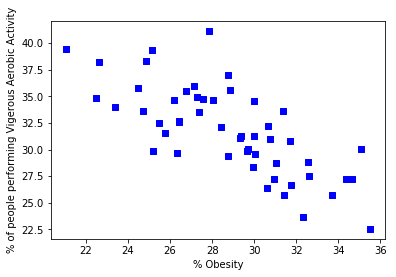

In [29]:
# X-axis: avg % obesity
# Y-axis: avg % of people performing vigerous aerobic activity
plt.scatter(obesity_data_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           vig_aerobic_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           marker='s',
           color='b')
plt.xlabel('% Obesity')
plt.ylabel('% of people performing Vigerous Aerobic Activity')
plt.show()